Real example: Assuming that the Wage is only related to the degree of training. And training may related to the education level and family background.

In [1]:
conda install -c anaconda python-graphviz

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import graphviz as gr

from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

In [3]:
def fn_variance(data, ddof=0):
    n=len(data)
    mean=sum(data)/n
    return sum((x-mean)** 2 for x in data)/(n-ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [4]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [5]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [6]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1

    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## 1.a Do not control for any covariates

$y_i = \tau*T_i+e_i$

In [7]:
tau = 3
corr = .8
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_1,tauhats_1,sehats_1,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 358.83it/s]


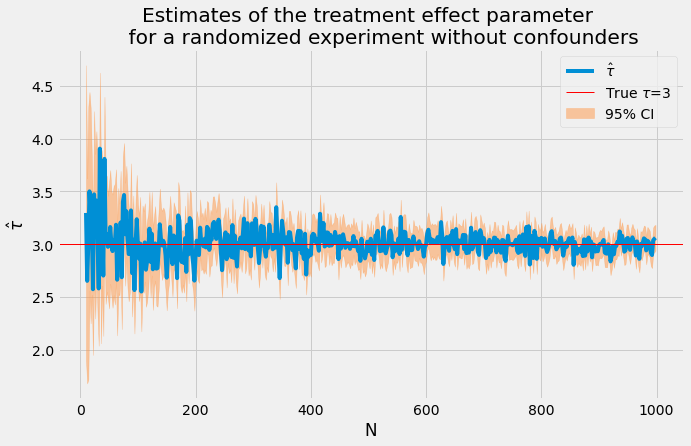

In [8]:
caption_1 = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues_1,tauhats_1,tau,lb,ub,caption_1)

### N=100

In [9]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(3.064714143507877, 0.17471298334357097)

In [10]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(3.0647141435078775, 0.17471298334357097)

### N=1000

In [11]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(3.04249780246147, 0.06438895012465787)

In [12]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(3.0424978024614715, 0.0643889501246579)


### Illustrate DGP with a DAG


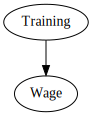

In [13]:
g1 = gr.Digraph()
g1.edge("Training", "Wage")

g1

### using a Monte Carlo experiment with sample size N=100 and N=1000, what the bias, RMSE and size of treatment effect estimate is in cases.

In [14]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:13<00:00, 142.89it/s]


In [15]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    



N=100: bias=-0.0013994763681438873, RMSE=0.20559521997575717, size=0.056
N=1000: bias=0.0006824711367435075, RMSE=0.06407391421143142, size=0.0515


## 1.b Control for all the covariates affect the outcome
## 2.a Do not control for any confounder

$y_i = \tau*T_i+\beta'*X_i+e_i$

In [16]:
tau = 3
corr = .8
conf=False
p = 10
p0 = 5 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_2,tauhats_2,sehats_2,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 326.38it/s]


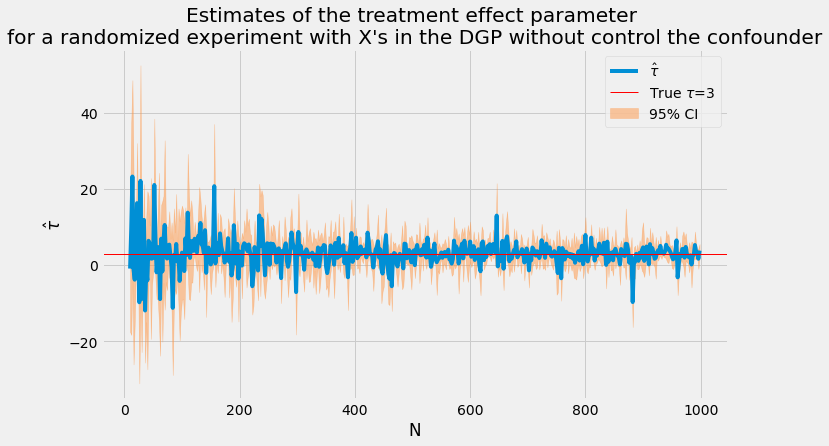

In [17]:
caption_2= """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP without control the confounder"""
fn_plot_with_ci(nvalues_2,tauhats_2,tau,lb,ub,caption_2)

### N=100

In [18]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,5,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(0.7760748353416302, 1.9930655720571162)

In [19]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(0.7760748353416307, 1.9930655720571162)

In [20]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(0.7760748353416307, 1.9930655720571162)

### N=1000

In [21]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,5,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(4.606421217874025, 1.3632145190039975)

In [22]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(4.606421217874026, 1.3632145190039975)


### Illustrate DGP with a DAG

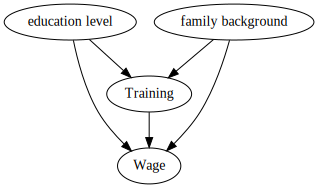

In [23]:
g2 = gr.Digraph()
g2.edge("education level", "Training")
g2.edge("education level", "Wage")
g2.edge("family background", "Wage")
g2.edge("family background", "Training")
g2.edge("Training", "Wage")
g2

### using a Monte Carlo experiment with sample size N=100 and N=1000, what the bias, RMSE and size of treatment effect estimate is in cases.

In [24]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,5,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 98.68it/s]


In [25]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.11047430927556401, RMSE=5.227361504729004, size=0.056
N=1000: bias=0.05232458385455023, RMSE=1.630995605808515, size=0.0515


If we control for all the covariates that affect the outcome, the treatment effect parameter and bias and RMSE will be higher.

## 2. control for the confounder

$y_i = \tau*T_i+\beta'*X_i+ \theta*U_i+e_i$

In [26]:
tau = 3
corr = .8
conf = True
p = 10
p0 = 5 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_3,tauhats_3,sehats_3,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 204.52it/s]


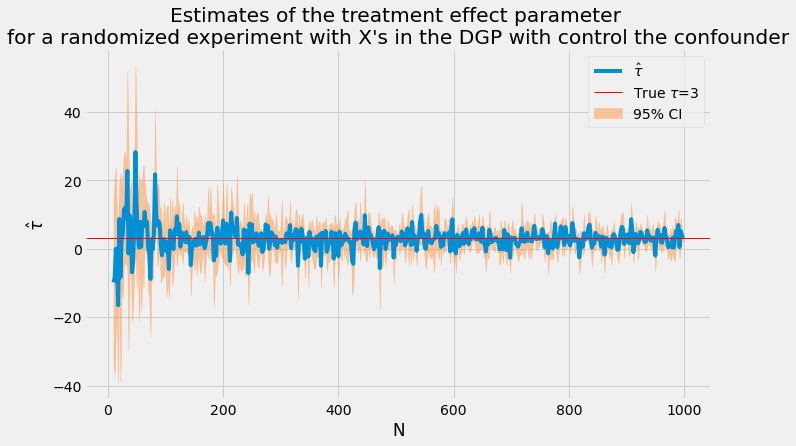

In [27]:
caption_3 = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP with control the confounder"""
fn_plot_with_ci(nvalues_3,tauhats_3,tau,lb,ub,caption_3)

### N=100

In [28]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,5,corr,conf = True)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(0.37423968180545897, 2.7684290143226553)

In [29]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(0.3742396818054574, 2.7684290143226553)

### N=1000

In [30]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,5,corr,conf = True)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(0.49723216781658186, 2.1526718042880817)

In [31]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(0.49723216781658086, 2.1526718042880817)


### Illustrate DGP with a DAG

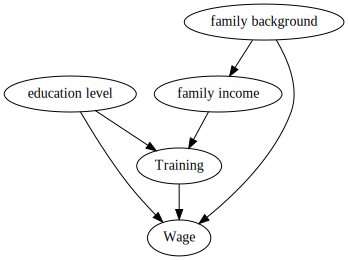

In [32]:
g3 = gr.Digraph()
g3.edge("education level", "Training")
g3.edge("education level", "Wage")
g3.edge("family income", "Training")
g3.edge("Training", "Wage")
g3.edge("family background", "family income")
g3.edge("family background", "Wage")
g3

### using a Monte Carlo experiment with sample size N=100 and N=1000, what the bias, RMSE and size of treatment effect estimate is in cases.

In [33]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,5,corr,conf=True)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 126.01it/s]


In [34]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.06306502968026209, RMSE=5.349696051283276, size=0.053
N=1000: bias=-0.004627209954370898, RMSE=1.6140837795481413, size=0.042


## 3.a Control for the variable in between the path from cause to effect

In [36]:
tau = 3
corr = .8
conf = True
p = 10
p0 = 5 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_4,tauhats_4,sehats_4,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf=True,flagX=1)
flagX=1

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 272.12it/s]


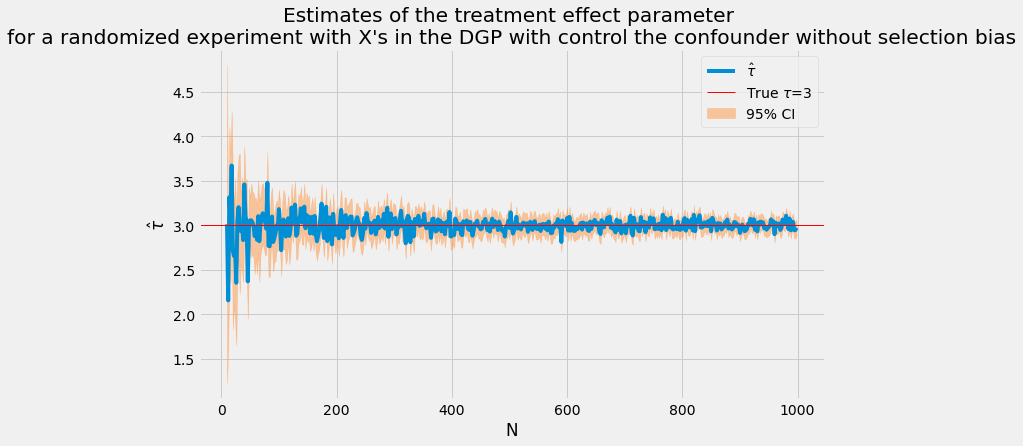

In [37]:
caption_4 = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP with control the confounder without selection bias"""
fn_plot_with_ci(nvalues_4,tauhats_4,tau,lb,ub,caption_4)

### N=100

In [38]:
N = 100
Yexp,T,X = fn_generate_data(tau,N,10,5,corr,conf=True,flagX=1)
Xobs = X[:,:p0]
covars = np.concatenate([T,Xobs],axis = 1)
mod = sm.OLS(Yexp,covars)
res = mod.fit()
tauhat = res.params[0]
se_tauhat = res.HC1_se[0]
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(2.950567800711871, 0.14905097728932767)

In [39]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(4.556483323475605, 3.5108954529714063)

### N=1000

In [40]:
N = 1000
Yexp,T,X = fn_generate_data(tau,N,10,5,corr,conf=True,flagX=1)
Xobs = X[:,:p0]
covars = np.concatenate([T,Xobs],axis = 1)
mod = sm.OLS(Yexp,covars)
res = mod.fit()
tauhat = res.params[0]
se_tauhat = res.HC1_se[0]
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(3.0051126734835876, 0.045248614885043115)

In [41]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(3.2667287722913314, 0.9942942876666034)

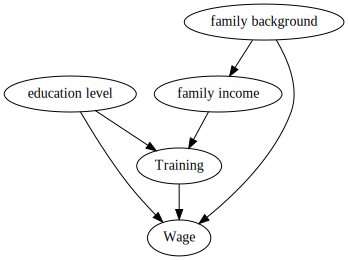

In [42]:
g4 = gr.Digraph()
g4.edge("education level", "Training")
g4.edge("education level", "Wage")
g4.edge("family income", "Training")
g4.edge("Training", "Wage")
g4.edge("family background", "family income")
g4.edge("family background", "Wage")
g4

### using a Monte Carlo experiment with sample size N=100 and N=1000, what the bias, RMSE and size of treatment effect estimate is in cases.

In [43]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,10,5,corr,conf=True,flagX=1)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
tauhats = tauhats + [tauhat]
sehats = sehats + [se_tauhat]    

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 122.05it/s]


In [44]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

## 3.b Do not Control for the variable in between the path from cause to effect

In [45]:
tau = 3
corr = .8
conf = True
p = 10
p0 = 5 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_5,tauhats_5,sehats_5,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)
flagX=2

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 237.66it/s]


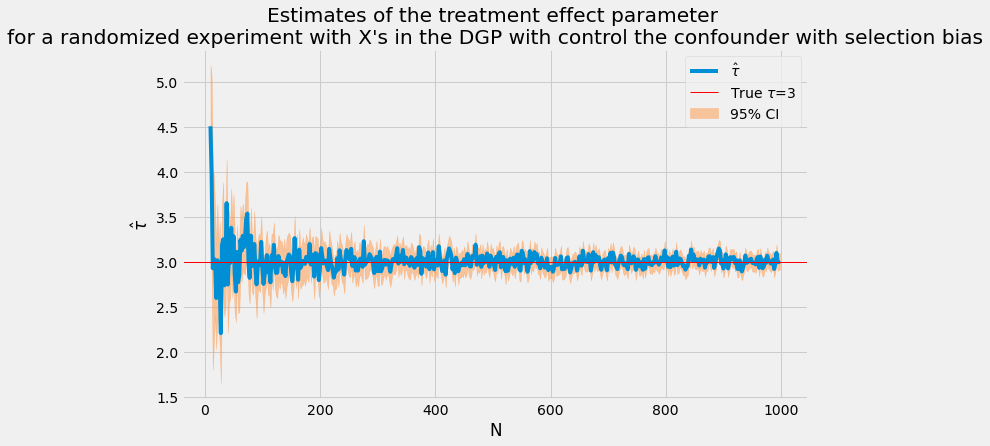

In [46]:
caption_5 = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP with control the confounder with selection bias"""
fn_plot_with_ci(nvalues_5,tauhats_5,tau,lb,ub,caption_5)

### N=100

In [47]:
N = 100
Yexp,T,X = fn_generate_data(tau,N,10,5,corr,conf=True,flagX=2)
Xobs1 = X[:,:np.int(p0/2)]
Xobs2 = X[:,-np.int(p0/2):]
covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
mod = sm.OLS(Yexp,covars)
res = mod.fit()
tauhat = res.params[0]
se_tauhat = res.HC1_se[0]
# n_values = n_values + [N]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(1.2861670681145494, 0.9698964645264697)

In [48]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(4.529594075385169, 8.42784633293128)

### N=1000

In [49]:
N = 1000
Yexp,T,X = fn_generate_data(tau,N,10,5,corr,conf=True,flagX=2)
Xobs1 = X[:,:np.int(p0/2)]
Xobs2 = X[:,-np.int(p0/2):]
covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
mod = sm.OLS(Yexp,covars)
res = mod.fit()
tauhat = res.params[0]
se_tauhat = res.HC1_se[0]
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(2.550697819892191, 0.2542699734505773)

In [50]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(-0.6518408137431881, 1.4572761752308965)

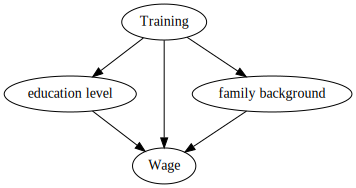

In [51]:
g5 = gr.Digraph()
g5.edge("education level", "Wage")
g5.edge("Training", "education level")
g5.edge("family background", "Wage")
g5.edge("Training", "family background")
g5.edge("Training", "Wage")
g5

### using a Monte Carlo experiment with sample size N=100 and N=1000, what the bias, RMSE and size of treatment effect estimate is in cases.

In [52]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,10,5,corr,conf=True,flagX=2)
        Xobs1 = X[:,:np.int(p0/2)]
        Xobs2 = X[:,-np.int(p0/2):]
        covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat] 


100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 110.75it/s]


In [53]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')